# Nonlinear generating functions (Chapter 2)

This notebook covers the code and explanation for the following experiments in Chapter 2:

* Experiment 2C
* Experiment 2D
* Experiment 2E

==========================================================================
* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [1]:
%matplotlib inline

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import torch

from torch.distributions import Normal, Uniform

mpl.style.use("seaborn-deep")

In Chapter 2 we explore a number of different types of models to illustrate the process of parameter estimation. We emphasize the difficulties involved as the generarating function becomes nonliner. We explore two types of models in this section of Chapter 2:
* Nonlinear, deterministic
* Nonlinear, probabilistic

In the following code, we will solve Bayes' Theorem with grid approximation where it is assumed that the parameters of the generative model have already been learnt. The aim of the code is for its setup to be as close as possible to the math notation in the accompanying text. 

Section 2.2 described five steps to be used in modeling. We will follow these steps in this notebook:
1. Define the experimental setting (states and outcomes)
2. Define the generative process
3. Define the generative model
4. Learn model parameters
5. Infer hidden states

## Experimental setting

We now begin Step 1: **Define the experimental setting (states and outcomes)**.

We will rely on the following variables:
* $x$: The true **hidden state** of the generative process.
* $y$: The **outcome** of a generative process, known as the **observation** for a generative model. This is the data the agent receives.

In this scenario the states of the generative process ($x$) denote the size of a food  source and the outcomes ($y$) are different levels of light intensity emitted from the food as a function of size. Using these observations, the agent needs to infer ("perceive") the hidden state of the generative process that generated the data it is receiving. 

## Experiment 2C: Nonlinear, determinsitic generative process

Here we change the generating function to be deterministic but nonlinear as in:

$
    \mathscr{E} = 
    \begin{cases}
        \mu = x^2+1                     & \text{Generating function} \\
    \end{cases}
$

We will return to the generative model we used in Experiment 2A except that now the generating function is a nonlinear transformation of $x$ as we will explore below:

$
    \mathcal{M} = 
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; \mu_y, \sigma^2_y) \approx \delta(x)& \text{Likelihood} \\
        p_{a_x, b_x}(x) = \mathcal{U}(x; a_x, b_x) & \text{Prior on } x \\
        \mu_y = \beta_0 + \beta_1 \phi(x) & \text{Generating function} \\
        \psi(x) = x^2 & \text{Nonlinear transform of x} \\
        \theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \} & \text{Linear parameters} \\
        \phi := \left \{\sigma^2_y \rightarrow 0, a_x = 0, b_x = 5 \right \} & \text{Other parameters} 
    \end{cases}
$

Additionally, we will change the grid to include negative values (even though you cannot have negative food size) and inspect the generating function.

First, consider the nonlinear transformation of $x$. Instead of $y = \beta_0 + \beta_1 x$, we instead pass $x$ through a nonlinear transformation function $\psi(x) = x^2$. Although $x$ is nonlinear, the relationship between the parameters is still linear which makes it a linear model.

In [4]:
# Grid ranges (the range of values x can take)
x_min = -2.5
x_max = 2.5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)

# Nonlinear transformation of x
def phi(x):
    return x ** 2

# Nonlinear generating function
def G_nl(x, beta_0, beta_1):
    y = beta_0 + beta_1 * phi(x)
    return y

<Figure size 432x288 with 0 Axes>

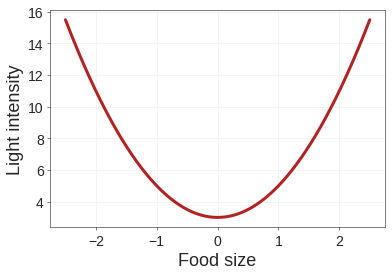

In [5]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, ax = plt.subplots(1, 1, facecolor=(1,1,1))

# Plot linear generating function on canvas
ax.plot(x_range, G_nl(x_range, beta_0=3, beta_1=2),
        c="#b22222",
        linewidth=3)

ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)

# Axis labels and styling
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

Now we perform Bayesian inference. Since we have already given a more thorough explanation in the previous notebook (*2b_linear_generating_functions.ipynb*) we will not focus on all the small details here and instead just execute the code. This experiment is the nonlinear analogue of Experiment 2A.

In [9]:
# Set up modeling objects
obs                = torch.Tensor((5,))
likelihood_mean    = G_nl(x_range, beta_0=3, beta_1=2)
likelihood_noise   = float(1./100.)
prior_a            = x_min
prior_b            = x_max + 0.01

# Define the components of the generative model
log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise)
log_prior          = Uniform(low=prior_a, high=prior_b)

# Calculate posterior
likelihood         = np.exp(log_likelihood.log_prob(obs))  # Call np.exp() to undo the log transformation
prior              = np.exp(log_prior.log_prob(x_range))   # Call np.exp() to undo the log transformation
gen_model          = likelihood * prior                    # p(x, y)  = p(y | x)p(x)
evidence           = torch.sum(gen_model)                  # p(y)     = integral_x of p(x, y); approximated in our grid with a sum
posterior          = gen_model / evidence                  # p(x | y) = p(x, y) / p(y)

<Figure size 432x288 with 0 Axes>

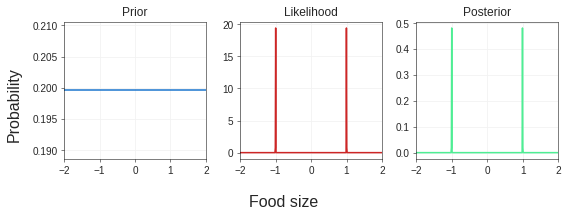

In [10]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.set_xlim([-2, 2])
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

Unfortunately, as we can see here, there are two possible answers due to the nature of this function. The agent is not able to determine which of these two possible beliefs is more likely. Unless we restrict our domain to $x \geq 0$, this will be an issue.

## Experiment 2D: Nonlinear, probabilistic generative model

Next we turn to a nonlinear generating function $y = x^2+1$. The rest of the setup is similar to Experiment 2B.

$
\begin{equation}
    \mathscr{E} = 
    \begin{cases}
        \mu = x^2+1                       & \text{Generating function} \\
        y \sim \mathcal{N}(\mu, \sigma^2 = 1)    & \text{Gaussian noise} \\
    \end{cases}
\end{equation}
$

$
\begin{equation}
    \mathcal{M} = 
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; \mu_y, \sigma^2_y) & \text{Likelihood} \\
        p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; \mu_x, \sigma^2_x) & \text{Prior on } x \\
        \mu_y = \beta_0 + \beta_1 \phi(x) & \text{Generating function} \\
        \psi(x) = x^2 & \text{Nonlinear transform of x} \\
        \theta := \left \{\beta_0 = 1, \beta_1 = 1 \right \}  & \text{Parameters} \\
        \phi := \left \{\sigma^2_y = 0.25, \mu_x = 4, \sigma^2_x = 0.25 \right \} & \text{Hyperparameters}
    \end{cases}
\end{equation}
$

We will first visualize the generating function with noise.

In [8]:
# Grid ranges (the range of values x can take)
x_min = 0.01
x_max = 5
x_points = 500

x_range = torch.linspace(start=x_min, end=x_max, steps=x_points)

# Set seed
torch.manual_seed(5454) 
E_nl = Normal(loc=G_nl(x_range, beta_0=1, beta_1=1), scale=1)

<Figure size 640x480 with 0 Axes>

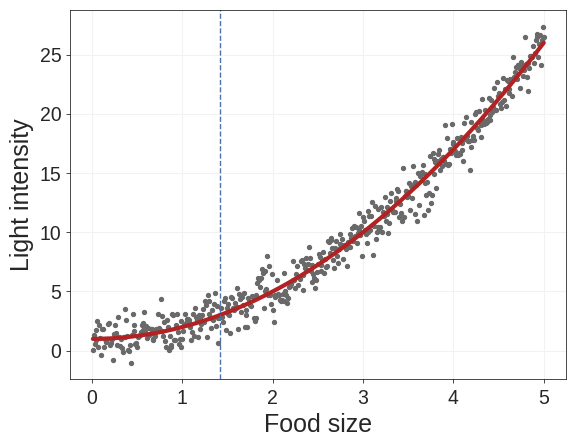

In [9]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range.tolist(), [G_nl(elem, beta_0=1, beta_1=1) for elem in x_range],
        c="#B22222", linewidth=3)

# Noisy samples
ax.scatter(x_range.tolist(), E_nl.sample().tolist(),
        c="#696969", s=8)

ax.axvline(x=np.sqrt(2), linestyle="dashed", linewidth=1)

# Axis labels and styling
ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

The dotted line in the above image indicates a hidden state of $x^* = \sqrt{2} = 1.414...$ which would generate the observation $y=3$.

In [10]:
# Set up modeling objects
obs                = torch.Tensor((3,))
likelihood_mean    = G_nl(x_range, beta_0=1, beta_1=1)
likelihood_noise   = 1
prior_mean         = 2
prior_noise        = 0.5

# Define the components of the generative model
log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise)
log_prior          = Normal(loc=prior_mean, scale=prior_noise)

# Calculate posterior
likelihood         = np.exp(log_likelihood.log_prob(obs))  # Call np.exp() to undo the log transformation
prior              = np.exp(log_prior.log_prob(x_range))   # Call np.exp() to undo the log transformation
gen_model          = likelihood * prior                    # p(x, y)  = p(y | x)p(x)
evidence           = torch.sum(gen_model)                  # p(y)     = integral_x of p(x, y); approximated in our grid with a sum
posterior          = gen_model / evidence                  # p(x | y) = p(x, y) / p(y)

<Figure size 640x480 with 0 Axes>

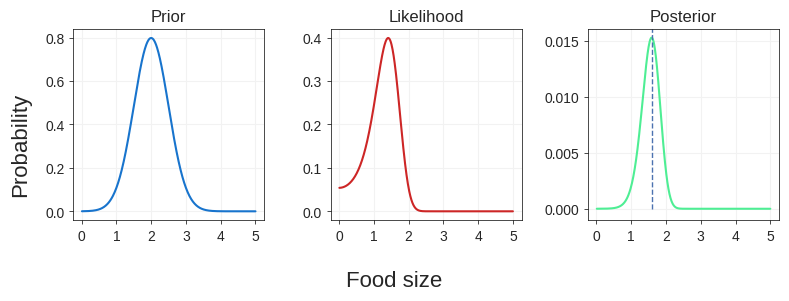

In [11]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].vlines(x=(np.argmax(posterior) + 1) / 100, ymin=0, ymax=0.016, linestyles="dashed", linewidth=1)
axes[2].set_ylim([-0.001, 0.016])

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [12]:
mode = (np.argmax(posterior) + 1) / 100
print(f'The posterior mode is {mode}. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 3 with a standard deviation of 1.')

The posterior mode is 1.590000033378601. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 3 with a standard deviation of 1.


## Experiment 2E

In this experiment we use the same generative model and generative process as in Experiment 2D except we make the following changes to the generative model:
* The new generating function for the model is $\mu_y = \beta_0 + \beta_1 x$
* The linear parameters are $\theta := \left \{\beta_0 = 3, \beta_1 = 2 \right \}$.
* The other parameters are $\phi := \left \{\sigma^2_y = 0.25, \mu_x = x, \sigma^2_x = 0.25 \right \}$.

This means the model *believes* that the generating process is linear when it is in fact nonlinear. We say this because our choice of likelihood within the generative model is an assumption we are making about the generating process. In this case it happens to be false.

First, we define the linear version of the generating function which is part of the generative model. The *true* generating function, part of the generative process, is actually nonlinear.

In [13]:
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

To avoid too much code repetition, we will create a simple `agent()` function that is able to perform inference given an observation. This function be heavily customized for our use case in a single state, single observation system with hard-coded parameters.

In [14]:
def agent(obs: torch.LongTensor, x_range: torch.FloatTensor, mode: bool = False) -> torch.FloatTensor:
    
    # Set up modeling objects
    likelihood_mean    = G(x_range, beta_0=3, beta_1=2)
    likelihood_noise   = 0.5
    prior_a            = x_min
    prior_b            = x_max + 1 

    # Define the components of the generative model
    log_likelihood     = Normal(loc=likelihood_mean, scale=likelihood_noise)
    log_prior          = Uniform(low=prior_a, high=prior_b)

    # Calculate posterior
    likelihood         = np.exp(log_likelihood.log_prob(obs))  # Call np.exp() to undo the log transformation
    prior              = np.exp(log_prior.log_prob(x_range))   # Call np.exp() to undo the log transformation
    gen_model          = likelihood * prior                    # p(x, y)  = p(y | x)p(x)
    evidence           = torch.sum(gen_model)                  # p(y)     = integral_x of p(x, y); approximated in our grid with a sum
    posterior          = gen_model / evidence                  # p(x | y) = p(x, y) / p(y)
    
    if mode:
        return (np.argmax(posterior).tolist() + 1) / 100
    
    return posterior

Now we can generate some observations and calculate the posterior. We will do this with different hidden states of $x$ and see how well the posterior predicts this hidden state. For this example, we will choose $x^* = 2$, $x^*=2.5$, and $x^*=3.5$.

In [15]:
probs     = {}
x_trues   = np.array([2, 2.5, 3.5])

for x_true in x_trues:
    
    # Generate observation
    E = Normal(loc=G_nl(x_true, beta_0=1, beta_1=1), scale=0.5)
    torch.manual_seed(7867)
    obs = E.sample()
    
    # Inference
    posterior = agent(obs, x_range)
    probs[str(x_true)] = posterior

<Figure size 640x480 with 0 Axes>

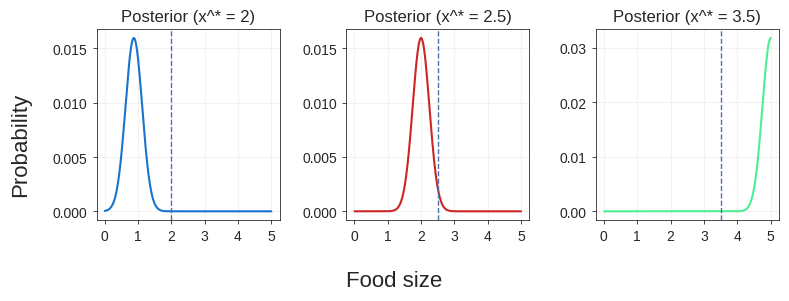

In [17]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), probs["2.0"], c="#1874cd")   # Posterior (x^*=2)
axes[1].plot(x_range.tolist(), probs["2.5"], c="#cd2626")   # Posterior (x^*=2)
axes[2].plot(x_range.tolist(), probs["3.5"], c="#4eee94")   # Posterior (x^*=2)

# Posterior mode and posterior axis
axes[0].axvline(x=2, linestyle="dashed", linewidth=1)
axes[1].axvline(x=2.5, linestyle="dashed", linewidth=1)
axes[2].axvline(x=3.5, linestyle="dashed", linewidth=1)

# Titles
axes[0].set_title("Posterior (x^* = 2)")
axes[1].set_title("Posterior (x^* = 2.5)")
axes[2].set_title("Posterior (x^* = 3.5)")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(0, 6, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

As we can see, with this generative model, with low and high true values of $x$, the agent's belief about $x$ is quite off. However it is not so far off for values in the middle. In this sense, the model might make some true predictions with an incorrect generative model depending on the state. From the perspective of a living organism, this approximation may be tolerable if food sizes tended to be concentrated in a small range 2-2.5 units.